# Desc

Tutaj chciałem zobaczyć feature output tego resneta (outputuje tensor shape=[2048] features), porównać dla obu zdjęć które features będą podobne i potem zobaczyć które piksele w każdym zdjęciu wpłynęły na wartość danego feature w outpucie. Nie za bardzo działa (myślałem że każdy feature będzie encodował jakiś 'koncept' a rozlewają się po całym obrazku)

In [14]:
import torch
from torchvision import models
import numpy as np

from matplotlib import pyplot as plt
import cv2

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
class ResnetFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(ResnetFeatureExtractor, self).__init__()
        self.model = model
        self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])
                
    def __call__(self, x):
        return self.feature_extractor(x)[:, :, 0, 0]

In [17]:
def load_img(path,imshape=(1024,1024)) -> np.ndarray:
    img = cv2.imread(path)
    return cv2.resize(img,imshape)

def img_to_tensor(img):
    return torch.Tensor(img).unsqueeze(0).view((1,3,*img.shape[:2])).to(device)

In [18]:
resnet = models.resnet50(pretrained=True).to(device)
model = ResnetFeatureExtractor(resnet)

/home/milte/anaconda3/envs/torch-cv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/milte/anaconda3/envs/torch-cv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


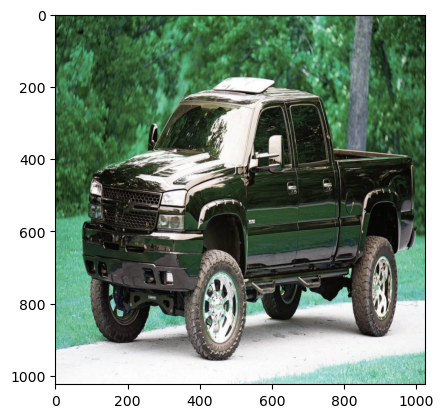

In [19]:
im1 = load_img("/home/milte/Desktop/ainspired/data/test_images/pickup.jpg")

plt.imshow(im1)
plt.show()

In [20]:
im1_tensor = img_to_tensor(im1)
features = model(im1_tensor)[0]
features.shape

torch.Size([2048])

In [21]:
features_np = features.cpu().detach().numpy()
feature_ids = sorted(np.arange(features_np.shape[0]),reverse=True,key=lambda x: features_np[x])
feature_ids[:5]

[1064, 617, 1501, 2018, 564]

In [22]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import RawScoresOutputTarget

In [23]:
class FeatureTarget(RawScoresOutputTarget):
    def __init__(self,feature) -> None:
        super().__init__()
        self.feature = feature
    def __call__(self, model_output):
        return model_output[self.feature]

In [24]:
target_layer = [resnet.layer4[-1]] # Last conv layer in ResNet
cam = GradCAM(model=model, target_layers=target_layer)

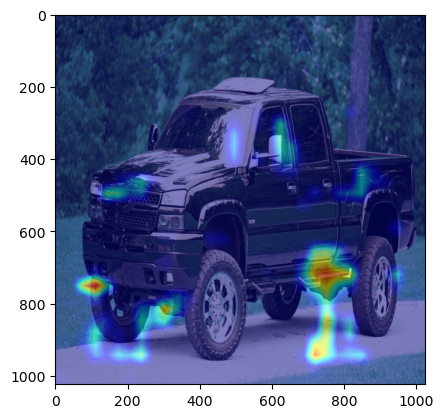

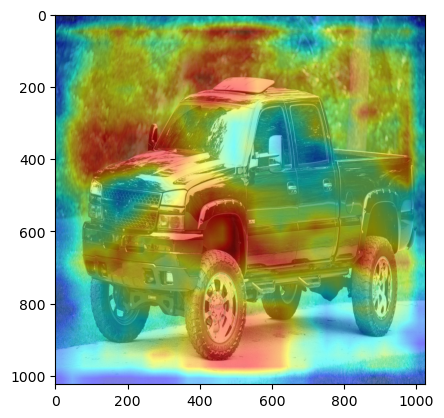

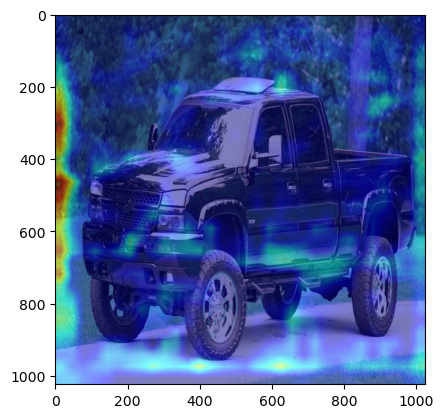

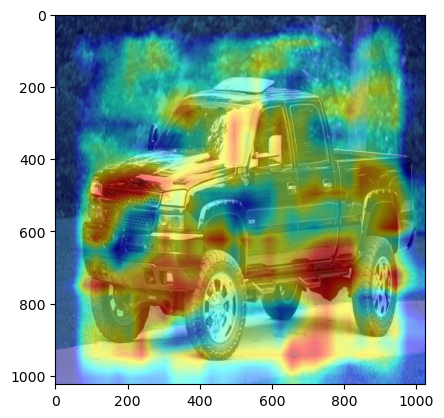

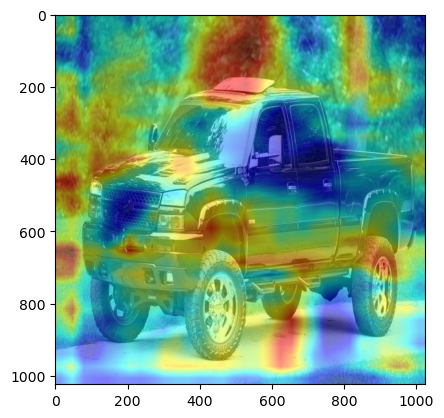

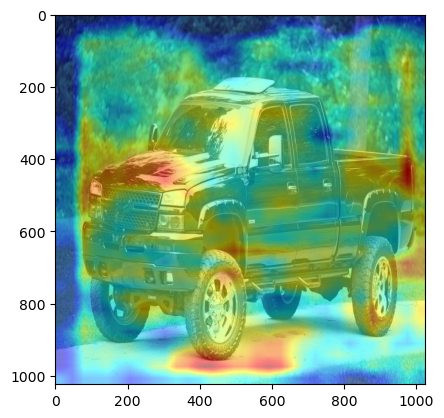

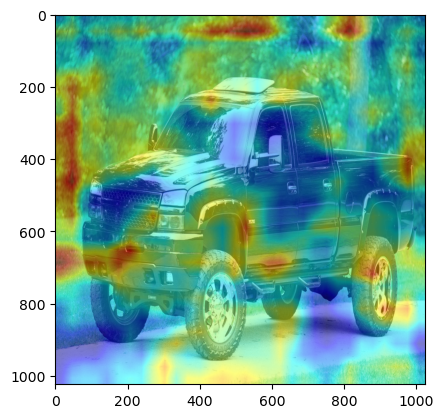

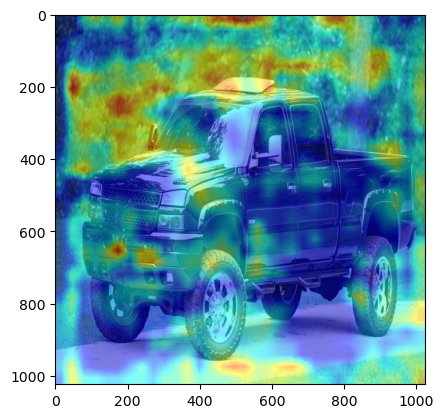

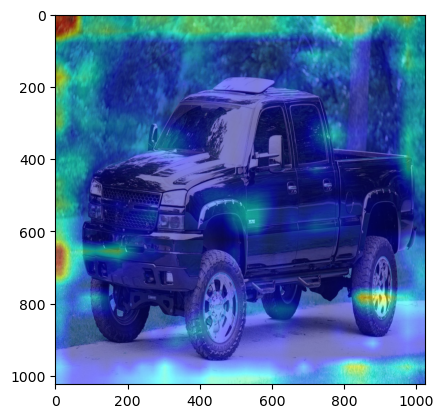

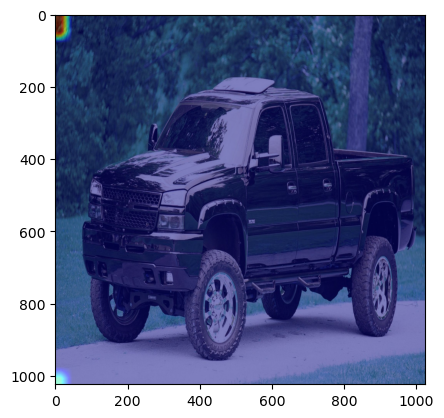

In [26]:
for i in feature_ids[:10]:
    grayscale_cam2 = cam(input_tensor=im1_tensor, targets=[FeatureTarget(i)])
    cam_image = show_cam_on_image(im1/255, grayscale_cam2[0], use_rgb=True)
    plt.imshow(cam_image)
    plt.show()